In [2]:
!pip install --user scprep phate magic-impute

### Imports

In [ ]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron

In [3]:
import pandas as pd
import numpy as np
import phate
import scprep
import magic

import matplotlib.pyplot as plt
import seaborn as sns

import time, os

# matplotlib settings for Jupyter notebooks only
%matplotlib inline
import pandas as pd
import umap
sns.set_style('ticks')

# Running Slingshot and Diffusion Pseudotime on EB data

In the last exercise, we ran both pseudotime methods on a relatively small dataset of fewer than 400 cells. Here, we're going to run both algorithms on a more complex dataset of human embryonic stem cells (hESCs) grown as Embryoid Bodies (EBs).

However, 16,000 cells is still a large dataset for slingshot. To save time, we're going to subsample the data to 6,000 cells.

## 1. Load EB Data (and download if needed)



In [4]:
home = os.path.expanduser('~')
file_path = os.path.join(home, 'scRNAseq', 'EBT_counts.pkl.gz')
if not os.path.exists(file_path):
    scprep.io.download.download_google_drive(id='1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM',
                        destination=os.path.dirname(file_path))
data = pd.read_pickle(file_path)

#### Subsample the data

In [5]:
np.random.seed(42)
data = scprep.select.subsample(data, n=6000)

In [6]:
data.head()

,FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),RP11-54O7.1 (ENSG00000230699),RP11-54O7.2 (ENSG00000241180),RP11-54O7.3 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),...,MT-ND4L (ENSG00000212907),MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAAGATCTCTGCTC-1_Day 00-03,0.0,1.232158,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.141399,0.871267,0.000000,4.086606,0.0,0.0,0.0,0.0,0.0
AAAGTTTGCCAAGT-1_Day 00-03,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.113778,...,0.0,3.150241,1.575121,1.113778,3.150241,0.0,0.0,0.0,0.0,0.0
AAATCAACGCAAGG-1_Day 00-03,0.0,0.000000,0.0,0.0,0.88042,0.0,0.0,0.0,0.0,0.880420,...,0.0,3.630067,1.245103,0.000000,4.129538,0.0,0.0,0.0,0.0,0.0
AAATCATGCAGTCA-1_Day 00-03,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,2.915423,1.303817,0.000000,3.449575,0.0,0.0,0.0,0.0,0.0
AAATCCCTAGATGA-1_Day 00-03,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.758612,...,0.0,3.638177,1.072840,0.000000,4.291359,0.0,0.0,0.0,0.0,0.0


#### Parse the index names to grab the sample information

In [7]:
sample = [ix.split('_')[1] for ix in data.index]
metadata= pd.DataFrame(sample, index=data.index, columns=['sample'])

### Running PHATE



In [8]:
phate_op = phate.PHATE()

data_phate = phate_op.fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

clusters = phate.cluster.kmeans(phate_op, n_clusters=12)
metadata['clusters_for_slingshot'] = scprep.utils.sort_clusters_by_values(clusters, -data_phate.iloc[:,0])

Calculating PHATE...
  Running PHATE on 6000 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.29 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.68 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 5.37 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.42 seconds.
    Calculating KMeans...
    Calculated KMeans in 23.15 seconds.
  Calculated landmark operator in 24.84 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.69 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.20 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 13.66 seconds.
Calculated PHATE in 44.78 seconds.


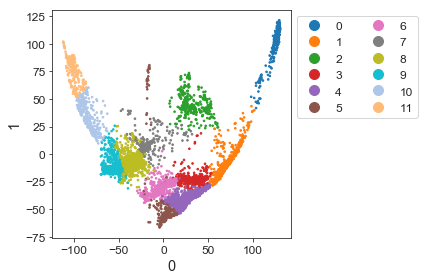

In [10]:
#%matplotlib inline
scprep.plot.scatter2d(data_phate, c=metadata['clusters_for_slingshot'], legend_anchor=(1,1))

## 2. Running trajectory inference methods

### Running Slingshot

Here we'll use default parameters for Slingshot, but set the start cluster.

In [17]:
tic = time.time()
# =======
# What is the the command to run Slingshot using `scprep`?
# Make sure to set the `start_cluster`
results = scprep.run.Slingshot(data_phate, metadata['clusters_for_slingshot'], start_cluster = )

# =======
print('Ran Slingshot in {:.2f} seconds'.format(time.time() - tic))

R[write to console]: Using full covariance matrix


Ran Slingshot in 65.01 seconds


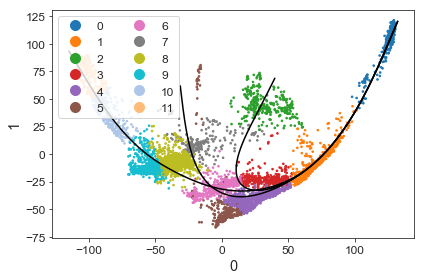

In [19]:
ax = scprep.plot.scatter2d(data_phate, c = metadata['clusters_for_slingshot'])

for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k')

### Running Diffusion Pseudotime

Here, we're going to use the diffusion pseudotime implementation from the original authors as provided in `scanpy`. This is faster than the implementation we derived in the previous exercise, but the results are comparable.

You will need to select the root cell using one of the methods previously described and select the number of branching events you think DPT should identify

In [31]:
import anndata, scanpy

# Create AnnData object
adata = anndata.AnnData(data)

# ========
# Select the root
adata.uns['iroot'] = np.argmax(data_phate.iloc[:,0].values)
# ========

# Run PCA
scanpy.pp.pca(adata)

# Identify nearest neighbors
scanpy.pp.neighbors(adata)

# Create the diffusion map
scanpy.tl.diffmap(adata)

# =======
# Run Diffusion Pseudotime, select a number of branchings to detect
scanpy.tl.dpt(adata, n_branchings=7)
# =======

metadata['dpt'] = adata.obs['dpt_pseudotime']
metadata['dpt_branch'] = adata.obs['dpt_groups'].astype(int)

### Plotting diffusion pseudotime

In two plots, visualize both the `dpt_branch` and `dpt` metadata values.

In [35]:
# =======
# Write code to plot the `dpt_branch` output


# =======



In [36]:
# =======
# Write code to plot the `dpt` output



# =======



### Discussion

In pairs:

1. Rerun DPT, but with a different number of branchings
2. How many branchings do produces a "good" set of trajectories?
3. How does this compare to the number of branchings observed in Slingshot?
4. Try setting `end_clusters` in Slingshot, how does this affect the output?

## Comparing the resolution of DPT and Slingshot

Here, we're going to dive deeper into how well DPT and Slingshot resolve later developmental transitions.

#### Rename the slingshot branches to be neater and concatenate them to `metadata`

In [37]:
results['pseudotime'].columns = ['slingshot{}'.format(i+1) for i in range(results['pseudotime'].shape[1])]

In [38]:
metadata = pd.concat((metadata, results['pseudotime']), axis=1)

#### Plotting Slingshot pseudotime vs DPT

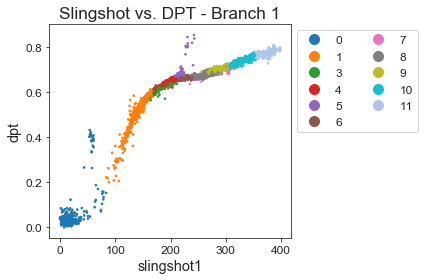

In [44]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot1'
mask = ~pd.isnull(metadata[curr_branch])

# =======
# Create a scatter plot with slingshot's `curr_branch` on the x-axis
# Because we only want to plot the cells that are not null,
# we can pass the mask created above to the `mask` arguement of
# `scprep.plot.scatter()`
ax = scprep.plot.scatter(metadata[curr_branch], metadata['dpt'],
                        c=metadata['clusters_for_slingshot'],
                         mask=mask,
                         title='Slingshot vs. DPT - {}'.format(curr_branch),
                        legend_anchor=(1,1))
# =======

#### Plot pseudotime values per cluster

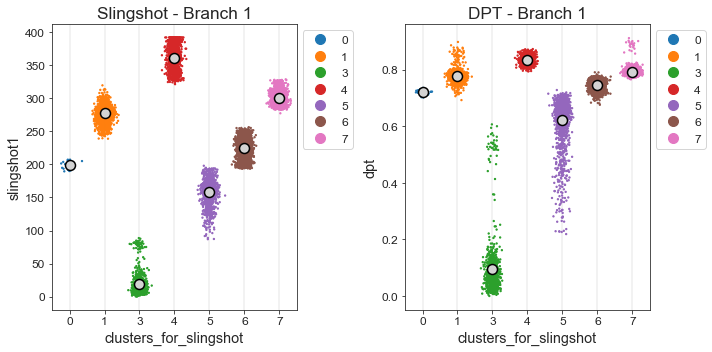

In [82]:
# Get all the cells that are on the desired branch.
curr_branch = '1'

mask = ~pd.isnull(metadata['slingshot{}'.format(curr_branch)])

fig, axes = plt.subplots(1,2, figsize=(10,5))

scprep.plot.jitter(metadata['clusters_for_slingshot'].loc[mask], metadata['slingshot{}'.format(curr_branch)].loc[mask],
                        c=metadata['clusters_for_slingshot'][mask],
                         title='Slingshot - Branch {}'.format(curr_branch),
                        legend_anchor=(1,1), ax=axes[0])

scprep.plot.jitter(metadata['clusters_for_slingshot'].loc[mask], metadata['dpt'].loc[mask],
                        c=metadata['clusters_for_slingshot'][mask],
                         title='DPT - Branch {}'.format(curr_branch),
                        legend_anchor=(1,1), ax=axes[1])

fig.tight_layout()

### Discussion

In your groups, answer the following questions:

1. Which method does better at finely resolving long-distance pseudotime relationships?
2. Is this different for different branches?
3. Based on what you know about each method, why do you think this is?

## Bonus

If you have extra time, go back to the top of this notebook and change the number of clusters passed to Slingshot. How does this change the output?